In [1]:
%load_ext autotime
import pandas as pd  # Tabular data
from glob import glob  # File pattern matching
import os  # Operating System
import geopandas as gpd  # Geospatial data
import re  # Regular expressions
import math
from tqdm.auto import tqdm  # Progress bars
from tqdm.contrib.concurrent import thread_map, process_map  # Parallel operations
import rapidfuzz # Fuzzy string matching
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 130)

import platform
if platform.system() == "Windows":
  prefix = "Z:/"
else:
  prefix = "ressci201900060-RNC2-Coastal/"

df = pd.concat(pd.read_csv(f) for f in ["meta.csv"])
# Filter to just shapefiles that have the CPS column defined
df = df[df.CPS & (df.n_lines > 0)]
df["Pixel_ER"] = (
    df.res.str.replace("(", "", regex=False).str.split(",").str[0].astype(float)
)
#df = df[["filename", "matched_image", "Pixel_ER"]]
# Testing with BigBay
# df = df[df.filename.str.contains("BigBay")]
df

,filename,matched_image,match_score,Source,n_lines,CPS,Photoscale,Pixel_Er,driver,dtype,nodata,width,height,count,crs,transform,blockxsize,blockysize,tiled,compress,interleave,GCPs,res,photometric,Pixel_ER
0,Retrolens/Northland/HelenaBay/Shorelines/HelenaBay_12DEC1985.shp,Retrolens/Northland/HelenaBay/Stack/HelenaBay_12DEC1985.tif,100.0,RL,47,True,True,True,GTiff,uint16,65535.0,36732,44101,1,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.26, 0.00, 1720090.68|\n| 0.00,-0.26, 6088098.48|\n| 0.00, 0.00, 1.00|",128.0,128,True,lzw,band,0,"(0.2642734532999967, 0.2642734532999967)",NaN,0.264273
1,Retrolens/Northland/HelenaBay/Shorelines/HelenaBay_03JAN1978.shp,Retrolens/Northland/HelenaBay/Stack/HelenaBay_03JAN1978.tif,100.0,RL,17,True,True,True,GTiff,uint16,65535.0,34088,33193,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.28, 0.00, 1720090.56|\n| 0.00,-0.28, 6085896.33|\n| 0.00, 0.00, 1.00|",128.0,128,True,lzw,pixel,0,"(0.2847753962000008, 0.2847753962000008)",NaN,0.284775
2,Retrolens/Northland/Owhata/Shorelines/Owhata_06NOV1942.shp,Retrolens/Northland/Owhata/Stack/Owhata_06NOV1942_mosaic.jp2,100.0,RL,10,True,True,True,JP2OpenJPEG,uint16,256.0,10940,6417,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.50, 0.00, 1613262.88|\n| 0.00,-0.50, 6095555.07|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,NaN,pixel,0,"(0.5027236098370393, 0.5027236098370481)",NaN,0.502724
3,MaxarImagery/HighFreq/Manawatu-Whanganui/WhanganuiSouth/Shorelines/WhanganuiSouth_14APR2006.shp,MaxarImagery/HighFreq/Manawatu-Whanganui/WhanganuiSouth/Imagery/Stack/WhanganuiSouth_14APR2006.tif,100.0,MAX,1,True,True,True,GTiff,uint8,NaN,7611,5001,3,NaN,"| 0.60, 0.00, 1769067.07|\n| 0.00,-0.60, 5576211.82|\n| 0.00, 0.00, 1.00|",128.0,128,True,lzw,pixel,3,"(0.6000000000000122, 0.5999999999999255)",NaN,0.600000
4,MaxarImagery/HighFreq/Southland/ColacBay/Shorelines/ColacBay_13MAR2020.shp,MaxarImagery/HighFreq/Southland/ColacBay/Imagery/Stack/ColacBay_13MAR2020.tif,100.0,MAX,7,True,True,True,GTiff,uint8,NaN,13572,7762,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.50, 0.00, 1205815.50|\n| 0.00,-0.50, 4854130.00|\n| 0.00, 0.00, 1.00|",128.0,128,True,lzw,pixel,0,"(0.5, 0.5)",NaN,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,Retrolens/Auckland/Omaha/Shorelines/Omaha_02MAY1996.shp,Retrolens/Auckland/Omaha/Stack/Omaha_02MAY1996.jp2,100.0,RL,1,True,True,True,JP2OpenJPEG,uint8,NaN,1694,2907,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 1.54, 0.00, 1758940.54|\n| 0.00,-1.54, 5979559.31|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,NaN,pixel,0,"(1.5437142739117524, 1.5437142739116012)",NaN,1.543714
1904,Retrolens/Auckland/Omaha/Shorelines/Omaha_02SEP1982.shp,Retrolens/Auckland/Omaha/Stack/Omaha_02SEP1982.jpg,100.0,RL,1,True,True,True,JPEG,uint8,NaN,3511,6047,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.73, 0.00, 1758988.90|\n| 0.00,-0.73, 5979563.54|\n| 0.00, 0.00, 1.00|",NaN,1,False,jpeg,pixel,0,"(0.7330681326, 0.7330681326)",ycbcr,0.733068
1905,Retrolens/Auckland/Omaha/Shorelines/Omaha_05DEC1973.shp,Retrolens/Auckland/Omaha/Stack/Omaha_05DEC1973.jp2,100.0,RL,3,True,True,True,JP2OpenJPEG,uint8,NaN,5192,9964,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.43, 0.00, 1759049.35|\n| 0.00,-0.43, 5979449.09|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,NaN,pixel

In [2]:
files = ["LDS_matches.csv", "WRAPS.csv", "RL_Waikato.csv"]
dfs = [df]
for f in files:
  dfs.append(pd.read_csv(f"{prefix}/Nick/{f}"))
df = pd.concat(dfs)
df

,filename,matched_image,match_score,Source,n_lines,CPS,Photoscale,Pixel_Er,driver,dtype,nodata,width,height,count,crs,transform,blockxsize,blockysize,tiled,compress,interleave,GCPs,res,photometric,Pixel_ER,matched_index_tiles,date,DSASDate,matched_date,matched_date_col
0,Retrolens/Northland/HelenaBay/Shorelines/HelenaBay_12DEC1985.shp,Retrolens/Northland/HelenaBay/Stack/HelenaBay_12DEC1985.tif,100.000000,RL,47.0,True,True,True,GTiff,uint16,65535.0,36732.0,44101.0,1.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.26, 0.00, 1720090.68|\n| 0.00,-0.26, 6088098.48|\n| 0.00, 0.00, 1.00|",128.0,128.0,True,lzw,band,0.0,"(0.2642734532999967, 0.2642734532999967)",NaN,0.264273,NaN,NaN,NaN,NaN,NaN
1,Retrolens/Northland/HelenaBay/Shorelines/HelenaBay_03JAN1978.shp,Retrolens/Northland/HelenaBay/Stack/HelenaBay_03JAN1978.tif,100.000000,RL,17.0,True,True,True,GTiff,uint16,65535.0,34088.0,33193.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.28, 0.00, 1720090.56|\n| 0.00,-0.28, 6085896.33|\n| 0.00, 0.00, 1.00|",128.0,128.0,True,lzw,pixel,0.0,"(0.2847753962000008, 0.2847753962000008)",NaN,0.284775,NaN,NaN,NaN,NaN,NaN
2,Retrolens/Northland/Owhata/Shorelines/Owhata_06NOV1942.shp,Retrolens/Northland/Owhata/Stack/Owhata_06NOV1942_mosaic.jp2,100.000000,RL,10.0,True,True,True,JP2OpenJPEG,uint16,256.0,10940.0,6417.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.50, 0.00, 1613262.88|\n| 0.00,-0.50, 6095555.07|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,NaN,pixel,0.0,"(0.5027236098370393, 0.5027236098370481)",NaN,0.502724,NaN,NaN,NaN,NaN,NaN
3,MaxarImagery/HighFreq/Manawatu-Whanganui/WhanganuiSouth/Shorelines/WhanganuiSouth_14APR2006.shp,MaxarImagery/HighFreq/Manawatu-Whanganui/WhanganuiSouth/Imagery/Stack/WhanganuiSouth_14APR2006.tif,100.000000,MAX,1.0,True,True,True,GTiff,uint8,NaN,7611.0,5001.0,3.0,NaN,"| 0.60, 0.00, 1769067.07|\n| 0.00,-0.60, 5576211.82|\n| 0.00, 0.00, 1.00|",128.0,128.0,True,lzw,pixel,3.0,"(0.6000000000000122, 0.5999999999999255)",NaN,0.600000,NaN,NaN,NaN,NaN,NaN
4,MaxarImagery/HighFreq/Southland/ColacBay/Shorelines/ColacBay_13MAR2020.shp,MaxarImagery/HighFreq/Southland/ColacBay/Imagery/Stack/ColacBay_13MAR2020.tif,100.000000,MAX,7.0,True,True,True,GTiff,uint8,NaN,13572.0,7762.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.50, 0.00, 1205815.50|\n| 0.00,-0.50, 4854130.00|\n| 0.00, 0.00, 1.00|",128.0,128.0,True,lzw,pixel,0.0,"(0.5, 0.5)",NaN,0.500000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,Retrolens/Waikato/TeMataBay/Shorelines/TeMataBay_09FEB1971.shp,Retrolens/Northland/MataiBay/Stack/MataiBay_11FEB1971.tif,82.352941,RL,3.0,OK,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,NaN,NaN,NaN,NaN,NaN
199,Retrolens/Waikato/Aotea/Shorelines/Aotea_12SEP1961.shp,Retrolens/Auckland/Orewa/Stack/Orewa_12SEP1961.jp2,85.714286,RL,1.0,OK,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.600000,NaN,NaN,NaN,NaN,NaN
200,Retrolens/Waikato/Pauanui_Tairua/Shorelines/Pauanui_Tairua_09FEB1971.shp,MaxarImagery/HighFreq/Waikato/Pauanui_Tairua/Imagery/Stack/Pauanui_Tairua_09FEB2019.tif,90.476190,RL,4.0,OK,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,NaN,NaN,NaN,NaN,NaN
201,Retrolens/Waikato/PortWaikato/Shorelines/PortWaikato_29MAR2012.shp,MaxarImagery/HighFreq/Waikato/PortWaikato/Imagery/Stack/PortWaikato_09MAR2016.tif,92.307692,RL,1.0,OK,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.534714,NaN,NaN,NaN,NaN,NaN


In [3]:
assert sum(df.Pixel_ER.isna()) == 0

Total UNCY:  
Total shoreline uncertainty (Et) is calculated as the root sum of squares of the pixel error (Ep), georeferencing error (Eg) and digitising error (Ed)  

$E_t = \sqrt{E_p^2 + E_g^2 + E_d^2}$

In [4]:
# Warning: do not interrupt this cell while it is running. Doing so can delete or empty shapefiles that are in the process of being written.

def get_scale(filename, DSASDate, year):
    # Find CSV for AOI
    bits = filename.split("/")
    terminator = min(
        bits.index("Stack") if "Stack" in bits else 1024,
        bits.index("Shorelines") if "Shorelines" in bits else 1024,
    )
    bits = bits[:terminator]
    csv_path_pattern = f"{prefix}{'/'.join(bits)}/*.csv"
    csv_candidates = glob(csv_path_pattern)
    if len(csv_candidates) == 0:
        raise ValueError(f"No CSV found for {csv_path_pattern}")
    elif len(csv_candidates) > 1:
        print(f"Ambiguous CSVs: {csv_candidates}")
        csv_candidates = [csv_candidates[0]]
    assert len(csv_candidates) == 1
    csv_filename = csv_candidates[0]
    try:
        csv = pd.read_csv(csv_filename, encoding="cp1252")
    except UnicodeDecodeError:
        # Excel file saved with .csv extension
        print(f"{csv_filename} is actually an Excel file")
        csv = pd.read_excel(csv_filename)
        csv.Date = csv.Date.astype(str)
    #if "RMSE" not in csv.columns:
        #print(f"{csv_filename} has no RMSE column")
    

    # Fuzzy string match dates. Lots of typos.
    matched_date, score, index = rapidfuzz.process.extractOne(query=DSASDate, choices=csv.Date.unique())
    if score < 80:
        # Terrible match score, just use year
        matched_date, score, index = rapidfuzz.process.extractOne(query=year, choices=csv.Date.unique())
        print(f"Matching {year} to {matched_date} with score {score} for {csv_filename}")
    elif DSASDate != matched_date:
        print(f"Matching {DSASDate} to {matched_date} with score {score} for {csv_filename}")
    if "RMSE" in csv.columns:
        filtered_csv = csv[(csv.Date == matched_date) & ~csv.RMSE.isna()]
    else:
        filtered_csv = csv[(csv.Date == matched_date)]
    scales = filtered_csv.Scale.unique()
    if len(scales) == 0:
        print(f"No scales found for {csv_filename} for date {DSASDate}, removing RMSE filter")
        filtered_csv = csv[(csv.Date.str.contains(matched_date))]
        scales = filtered_csv.Scale.unique()
        print(f"Scales now: {scales}")
        if len(scales) == 0:
            print(f"Still no scales found for {csv_filename} for date {matched_date}, reducing date filter just to year from filename {year}")
            filtered_csv = csv[(csv.Date.str.contains(year))]
            scales = filtered_csv.Scale.unique()
            print(f"Scales now: {scales}")
    if len(scales) > 1:
        scales = filtered_csv.Scale.value_counts()
        print(f"Ambiguous scales found for {csv_candidates[0]} for date {DSASDate}: {scales}. Taking {scales.index[0]}")
        scales = [scales.index[0]]
    if len(scales) == 0:
        print(f"Can't find a scale for {filename}")
    assert len(scales) == 1
    return scales[0]


def get_Georef_ER(scale):
    if not scale:
        return pd.NA
    try:
        scale = float(scale)
    except ValueError:
        raise ValueError(f"Can't convert {scale} to float")
    if scale < 20000:
        return 3.61
    elif scale < 30000:
        return 4.2
    else:
        return 5.03


CPS_error_lookup = {1: 0.43, 2: 0.73, 3: 0.97, 4: 2.07, 5: 8.59}

def get_source(filename, shapefile):
    if "Source" not in shapefile.columns:
        #print(f"{filename} has no Source")
        if filename.startswith("Retrolens"):
            return "RL"
        elif filename.startswith("MaxarImagery/HighFreq"):
            return "MAX"
        else:
            return "Unknown"
    else:
        sources = shapefile.Source.unique()
        if len(sources) == 0 or not sources[0]:
            #print(f"{filename} has no sources")
            if filename.startswith("Retrolens"):
                return "RL"
            elif filename.startswith("MaxarImagery/HighFreq"):
                return "MAX"
            else:
                return "Unknown"
        elif len(sources) == 1:
            return sources[0]
        elif len(sources) > 1:
            print(f"{filename} has ambiguous sources: {sources}")
            return sources[0]
    return "Unknown"

def process_shapefile(tup):
    i,row=tup
    filename=row.filename
    year = re.search(r'(\d{4})', filename).group(1)
    try:
        shapefile = gpd.read_file(prefix + filename)
        if "CPS" not in shapefile.columns:
            print(f"{filename} has no CPS")
            return
        original_shapefile = shapefile.copy()
    except:
        print(f"Can't read {filename}")
        return
    if len(shapefile) == 0:
        print(f"{filename} is empty")
        return
    
    source = get_source(filename, shapefile)

    if source in ["MAX", "Max", "max", "PLE", "CRI", "NEO", "PNE", "GE1", "JIN", "JIL", "SAT", "VEX"]:
        photoscale = pd.NA
        Georef_ER = 2.02
    elif source == "LDS":
        photoscale = pd.NA
        Georef_ER = 0
    elif source in ["RL", "RLN", "RLS", "Rl", "RS"]:
        if "Photoscale" in shapefile.columns and 0 not in shapefile.Photoscale:
            photoscales = shapefile.Photoscale.unique()
            if len(photoscales) == 0:
                print(f"{filename} has no photoscale")
            elif len(photoscales) == 1:
                photoscale = photoscales[0]
                Georef_ER = get_Georef_ER(photoscale)
            elif len(photoscales) > 1:
                print(f"{filename} has ambiguous photoscales: {photoscales}")
                photoscale = shapefile.Photoscale
                Georef_ER = shapefile.Photoscale.map(get_Georef_ER)
            #print(f"Found photoscale in shapefile: {photoscale}")
        else:
            if "DSASdate" in shapefile.columns:
                shapefile["DSASDate"] = shapefile.DSASdate
            elif "DSAS_NZDAT" in shapefile.columns:
                shapefile["DSASDate"] = shapefile.DSAS_NZDAT
            elif "DSASDate" not in shapefile.columns:
                print(f"{filename} has no DSASDate")
                shapefile["DSASDate"] = year

            if "Date" in shapefile.columns and all(shapefile.Date == shapefile.DSASDate):
                shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")

            dates = shapefile.DSASDate.unique()
            if len(dates) > 1:
                print(f"{filename} has ambiguous DSASDates: {dates}")
            if len(dates) == 0 or not dates[0]:
                print(f"{filename} has no DSASDate")
                DSASDate = year
            else:
                DSASDate = shapefile.DSASDate.unique()[0].lstrip("0")

            try:
                photoscale = get_scale(filename, DSASDate, year)
            except Exception as e:
                print(f"Got {e} when trying to get_scale for {filename}, {DSASDate}, {year}. Skipping")
                return
            Georef_ER = get_Georef_ER(photoscale)
    else:
        print(f"Source {source} not known, assuming MAX")
        photoscale = pd.NA
        Georef_ER = 2.02

    # Store inputs in shapefile
    shapefile["Photoscale"] = photoscale
    shapefile["Georef_ER"] = Georef_ER
    shapefile["Pixel_Er"] = row.Pixel_ER

    # Calculate Total_UNCY
    Ep = row.Pixel_ER
    for i, row in shapefile.iterrows():
        if row.CPS:
            row.CPS = float(row.CPS)
        if row.CPS not in CPS_error_lookup:
            #print(f"{row.CPS} not in CPS_error_lookup: {CPS_error_lookup}, skipping")
            continue
        Ed = CPS_error_lookup[row.CPS]
        # Override Taranaki Cliff Georef_ER
        if row.get("Proxy") and float(row.Proxy) in [3,4] and "Taranaki" in filename:
            #print(f"Overriding {row.Georef_ER} Georef_ER to 2.596504")
            shapefile.loc[i, "Georef_ER"] = 2.596504
            Eg = 2.596504
        else:
            Eg = row.Georef_ER
        if pd.isna(Eg):
            continue
        Et = math.sqrt(Ep**2 + Eg**2 + Ed**2)
        shapefile.loc[i, "Total_UNCY"] = Et
    #if type(photoscale) == pd.Series:
    #display(filename, shapefile)
    # To write results back to file:
    assert len(shapefile) > 0
    #shapefile.to_file(prefix+filename)

for tup in tqdm(df.iterrows(), total=len(df)):
    process_shapefile(tup)
#thread_map(process_shapefile, df.iterrows(),total=len(df))

  0%|          | 0/2591 [00:00<?, ?it/s]

Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/HelenaBay/*.csv when trying to get_scale for Retrolens/Northland/HelenaBay/Shorelines/HelenaBay_12DEC1985.shp, 12/12/1985, 1985. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/HelenaBay/*.csv when trying to get_scale for Retrolens/Northland/HelenaBay/Shorelines/HelenaBay_03JAN1978.shp, 3/01/1978, 1978. Skipping
Ambiguous CSVs: ['ressci201900060-RNC2-Coastal/Retrolens/Northland/Owhata/Owhata1.csv', 'ressci201900060-RNC2-Coastal/Retrolens/Northland/Owhata/Owhata.csv']
No scales found for ressci201900060-RNC2-Coastal/Retrolens/Northland/Owhata/Owhata1.csv for date 6/11/1942, removing RMSE filter
Scales now: [16000]
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/NinetyMile1/*.csv when trying to get_scale for Retrolens/Northland/NinetyMile1/Shorelines/NinetyMile1_24NOV1979.shp, 24/11/1979, 1979. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Nort

/tmp/ipykernel_484179/3046519458.py:155: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/Ngunguru/*.csv when trying to get_scale for Retrolens/Northland/Ngunguru/Shorelines/Ngunguru_20FEB1984.shp, 20/02/1984, 1984. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/Ngunguru/*.csv when trying to get_scale for Retrolens/Northland/Ngunguru/Shorelines/Ngunguru_05MAR1946.shp, 5/03/1946, 1946. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/Ngunguru/*.csv when trying to get_scale for Retrolens/Northland/Ngunguru/Shorelines/Ngunguru_17MAR1961.shp, 17/03/1961, 1961. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/Whananaki/*.csv when trying to get_scale for Retrolens/Northland/Whananaki/Shorelines/Whananaki_11OCT1963.shp, 11/10/1963, 1963. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/NinetyMile1/*.csv when trying to get_scale for Retrolens/Northland/NinetyMile1/Shorelines/NinetyMile1_04FEB1

/tmp/ipykernel_484179/3046519458.py:155: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


Matching 10/06/1948 to 10/6/1948 with score 94.73684210526316 for ressci201900060-RNC2-Coastal/Retrolens/Bay of Plenty/PukehinaBeach/PukehinaBeach.csv
Ambiguous scales found for ressci201900060-RNC2-Coastal/Retrolens/Wellington/Petone/Petone.csv for date 16/02/1995: Scale
5000    6
8000    1
Name: count, dtype: int64. Taking 5000
Matching 12/04/1973 to 12/04/1973 0:00 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Wellington/Ngawi/Ngawi.csv
Matching 22/08/1961 to 22/08/1961 0:00:00 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Wellington/PukeruaBay/PukeruaBay.csv
Ambiguous scales found for ressci201900060-RNC2-Coastal/Retrolens/Wellington/KapitiSouth/KapitiSouth.csv for date 17/04/1952: Scale
17455    2
18909    1
Name: count, dtype: int64. Taking 17455
Matching 27/09/1944 to 27/09/1944 0:00 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Wellington/Tora/Tora.csv
Matching 27/09/1944 to 27/09/1944 0:00 with score 90.0 for ressci201900060-RNC2-Coastal/

/tmp/ipykernel_484179/3046519458.py:155: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/ArangaBeach/*.csv when trying to get_scale for Retrolens/Northland/ArangaBeach/Shorelines/ArangaBeach_20MAR1961.shp, 20/03/1961, 1961. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/ArangaBeach/*.csv when trying to get_scale for Retrolens/Northland/ArangaBeach/Shorelines/ArangaBeach_28MAY1942.shp, 28/05/1942, 1942. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/ArangaBeach/*.csv when trying to get_scale for Retrolens/Northland/ArangaBeach/Shorelines/ArangaBeach_30SEP1952.shp, 30/09/1952, 1952. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/TakouBay/*.csv when trying to get_scale for Retrolens/Northland/TakouBay/Shorelines/TakouBay_04FEB1959.shp, 4/02/1959, 1959. Skipping
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/TakouBay/*.csv when trying to get_scale for Retrolens/Northland/TakouBay/Shorelines/

/tmp/ipykernel_484179/3046519458.py:155: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


ressci201900060-RNC2-Coastal/Retrolens/Southland/Toetoes_Harbour/Toetoes_Harbour.csv is actually an Excel file
ressci201900060-RNC2-Coastal/Retrolens/Southland/Toetoes_Harbour/Toetoes_Harbour.csv is actually an Excel file
Matching 1938 to 1938-10-04 00:00:00 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Southland/Toetoes_Harbour/Toetoes_Harbour.csv
ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoesBay_east/ToetoesBay_east.csv is actually an Excel file
Matching 1962 to 1962-01-03 00:00:00 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoesBay_east/ToetoesBay_east.csv


/tmp/ipykernel_484179/3046519458.py:155: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoesBay_east/ToetoesBay_east.csv is actually an Excel file


/tmp/ipykernel_484179/3046519458.py:155: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoesBay_east/ToetoesBay_east.csv is actually an Excel file
No scales found for ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoesBay_east/ToetoesBay_east.csv for date 15/03/1951, removing RMSE filter
Scales now: [15900]
ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoesBay_east/ToetoesBay_east.csv is actually an Excel file
Matching 1969 to 1969-12-02 00:00:00 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoesBay_east/ToetoesBay_east.csv
ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoesBay_east/ToetoesBay_east.csv is actually an Excel file


/tmp/ipykernel_484179/3046519458.py:155: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoeBay_west/ToetoeBay_West.csv is actually an Excel file
Matching 1962 to 1962-01-03 00:00:00 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoeBay_west/ToetoeBay_West.csv
ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoeBay_west/ToetoeBay_West.csv is actually an Excel file
ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoeBay_west/ToetoeBay_West.csv is actually an Excel file
Matching 28/11/1978 to 28/11/1998 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoeBay_west/ToetoeBay_West.csv
ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoeBay_west/ToetoeBay_West.csv is actually an Excel file
ressci201900060-RNC2-Coastal/Retrolens/Southland/ToetoeBay_west/ToetoeBay_West.csv is actually an Excel file
Matching 8/10/1985 to 18/10/1984 with score 84.21052631578947 for ressci201900060-RNC2-Coastal/Retrolens/Southland/CosyNook/CosyNook.csv
ressci201900060-RNC2-Coastal/Retrolens/So

/tmp/ipykernel_484179/3046519458.py:155: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


Ambiguous scales found for ressci201900060-RNC2-Coastal/Retrolens/Tasman/RuataniwhaInlet/RuataniwhaInlet.csv for date 11/10/1950: Scale
17400    6
16700    1
Name: count, dtype: int64. Taking 17400
Matching 1980 to 30/01/1980 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Tasman/RuataniwhaInlet/RuataniwhaInlet.csv
Retrolens/Tasman/Totaranui/Shorelines/Totaranui_09APR1965.shp has ambiguous DSASDates: ['09/04/1965' '9/04/1965']
Retrolens/Tasman/Totaranui/Shorelines/Totaranui_08FEB1952.shp has ambiguous DSASDates: ['08/02/1952' '8/02/1952']
Matching 18/09/1985 to 13/09/1985 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Tasman/MoutereSpit/MoutereSpit.csv


/tmp/ipykernel_484179/3046519458.py:155: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")
/tmp/ipykernel_484179/3046519458.py:155: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


ressci201900060-RNC2-Coastal/Retrolens/Manawatu/Akitio/Akitio.csv is actually an Excel file
ressci201900060-RNC2-Coastal/Retrolens/Manawatu/Akitio/Akitio.csv is actually an Excel file


/tmp/ipykernel_484179/3046519458.py:155: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")
/tmp/ipykernel_484179/3046519458.py:155: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


Matching 29/12/1985 to 29/10/1985 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Manawatu/HokioBeach/HokioBeach.csv
Matching 19/10/1985 to 29/10/1985 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Manawatu/SantoftForest_Rangitikei/SantoftForest_Rangitikei.csv
No scales found for ressci201900060-RNC2-Coastal/Retrolens/Manawatu/HimatangiBeach_South/HimatangiBeach_South.csv for date 15/03/1939, removing RMSE filter
Scales now: [10800]
Retrolens/Auckland/Tapapakanga/Shorelines/Tapapakanga_02JAN2004.shp has ambiguous DSASDates: [None '02/01/2004']
Retrolens/Auckland/Tapapakanga/Shorelines/Tapapakanga_02JAN2004.shp has no DSASDate
Matching 2004 to 2/01/2004 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Auckland/Tapapakanga/Tapapakanga.csv
Matching 29/09/1995 to 29/09/1998 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Canterbury/AshburtonRiver_North/AshburtonRiver_North.csv
Matching 24/09/1980 to 25/09/1980 with score 90.0 for ressci201900060-

/tmp/ipykernel_484179/3046519458.py:155: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


Ambiguous scales found for ressci201900060-RNC2-Coastal/Retrolens/Canterbury/OpihiRiver_RangitataRiver/OpihiRiver_RangitataRiver.csv for date 9/09/1954: Scale
17400    5
16700    1
Name: count, dtype: int64. Taking 17400
Matching 28/12/1984 to 28/10/1984 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Canterbury/SouthNewBrighton/SouthNewBrighton.csv
Matching 19/09/1975 to 17/09/1975 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Canterbury/RakaiaRiver_North/RakaiaRiver_North.csv
Matching 22/06/1938 to 22/05/1938 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Canterbury/WainononLagoon_PareoaRiver/WainonoLagoon_PareoraRiver.csv
Matching 4/03/1967 to 04/03/1967 with score 94.73684210526316 for ressci201900060-RNC2-Coastal/Retrolens/Canterbury/WainononLagoon_PareoaRiver/WainonoLagoon_PareoraRiver.csv
No scales found for ressci201900060-RNC2-Coastal/Retrolens/Tasman/MoutereRiver/MoutereRiver.csv for date 19/05/1958, removing RMSE filter
Scales now: [44500]

/tmp/ipykernel_484179/3046519458.py:155: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


Ambiguous scales found for ressci201900060-RNC2-Coastal/Retrolens/Southland/WaipapaPoint/WaipapaPoint.csv for date 25/02/1978: Scale
27000    4
49000    2
Name: count, dtype: int64. Taking 27000


/tmp/ipykernel_484179/3046519458.py:155: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


Matching 17/03/1975 to 17/02/1975 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Southland/MartinsBay/MartinsBay.csv
Matching 7/10/1985 to 17/10/1985 with score 94.73684210526316 for ressci201900060-RNC2-Coastal/Retrolens/Southland/HaldaneBay/HaldaneBay.csv
Matching 16/12/1945 to 16/10/1945 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Taranaki/PariokariwaPoint/PariokariwaPoint.csv
Retrolens/Taranaki/TongaporutuRiver/Shorelines/TongaporutuRiver_07NOV1970.shp has ambiguous DSASDates: ['07/11/1970' '7/11/1970']
Ambiguous scales found for ressci201900060-RNC2-Coastal/Retrolens/Taranaki/TongaporutuRiver/TongaporutuRiver.csv for date 7/11/1970: Scale
12300    3
23700    1
Name: count, dtype: int64. Taking 12300
Matching 18/10/1985 to 18/10/1984 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Southland/OretiBeach_West/OretiBeach_West.csv
Retrolens/Auckland/Orewa/Shorelines/Orewa_01MAR1988.shp has ambiguous DSASDates: ['01/03/1988' '1/03/1988']
Matching 199

In [5]:
!./aggregate_shapefiles_to_geojson.py

./aggregate_shapefiles_to_geojson.py:36: TqdmWarning: Iterable length 3011 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  df = gpd.GeoDataFrame(pd.concat(process_map(read, df.filename))).to_crs(epsg=4326)
100%|███████████████████████████████████████| 3011/3011 [00:48<00:00, 62.69it/s]
/home/nyou045/.local/lib/python3.8/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as NZGD2000 / New Zealand Transverse Mercator 2000 (the single non-null crs provided).
  warnings.warn(


In [6]:
df = gpd.read_file("shorelines.geojson")
df.Total_UNCY.describe()

count                 22266
unique                 2943
top       2.295931183637698
freq                    987
Name: Total_UNCY, dtype: object

In [7]:
df.Source.value_counts()

Source
RL     8875
LDS    5705
MAX    5631
RLN     760
PLE     397
Max     326
NEO     296
CRI     154
VEX      46
PNE      36
RLS      30
GE1      27
max      26
JIL      18
JIN      16
RS        6
WV3       2
SAT       2
Rl        1
Name: count, dtype: int64

In [8]:
df[df.Proxy.isin(["3","4"]) & df.filename.str.contains("Taranaki")].Region.value_counts(dropna=False)

Region
Taranaki          918
NorthTaranaki     278
SouthTaranaki     232
North Taranaki    117
South Taranaki     13
NothTaranaki        8
None                2
Name: count, dtype: int64

In [9]:
df.Total_UNCY.isna().value_counts()

Total_UNCY
False    22266
True       538
Name: count, dtype: int64

In [10]:
gpd.read_file("MaxarImagery/HighFreq/Auckland/Whatipu/Shorelines/Whatipu_24DEC2009.shp")

,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,CPS,Proxy,Photoscale,Georef_ER,Pixel_Er,Total_UNCY,geometry
0,0,Auckland,Whatipu,2009-12-24,24/12/2009,MF,1000,None,MAX,5,1,None,2.02,0.5,8.838467,"LINESTRING (1734247.512 5899019.483, 1734230.579 5899022.129, 1734211.000 5899022.129, 1734197.241 5899023.187, 1734178.191 58..."
1,0,Auckland,Whatipu,2009-12-24,24/12/2009,MF,1000,None,MAX,5,1,None,2.02,0.5,8.838467,"LINESTRING (1731185.792 5901617.741, 1731189.138 5901634.468, 1731190.725 5901659.868, 1731193.371 5901681.035, 1731198.663 59..."
2,0,Auckland,Whatipu,2009-12-24,24/12/2009,MF,1000,None,MAX,5,1,None,2.02,0.5,8.838467,"LINESTRING (1731117.435 5902468.701, 1731118.727 5902493.505, 1731120.711 5902503.427, 1731127.987 5902523.271, 1731139.893 59..."
3,0,Auckland,Whatipu,2009-12-24,24/12/2009,MF,1000,None,MAX,5,1,None,2.02,0.5,8.838467,"LINESTRING (1731118.065 5904434.228, 1731111.252 5904445.605, 1731115.221 5904453.542, 1731121.571 5904463.861, 1731124.746 59..."
4,0,Auckland,Whatipu,2009-12-24,24/12/2009,MF,1000,None,MAX,3,1,None,2.02,0.5,2.295931,"LINESTRING (1731233.049 5905141.438, 1731230.734 5905142.761, 1731227.096 5905145.407, 1731222.466 5905149.707, 1731218.497 59..."
5,0,Auckland,Whatipu,2009-12-24,24/12/2009,MF,1000,None,MAX,3,1,None,2.02,0.5,2.295931,"LINESTRING (1731092.202 5905598.419, 1731088.763 5905599.213, 1731084.794 5905599.742, 1731081.354 5905600.271, 1731078.444 59..."


In [11]:
missing_UNCY = pd.Series(df[df.Total_UNCY.isna()].filename.unique()).sort_values()
display(missing_UNCY)
try:
  missing_UNCY.to_csv(prefix+"Nick/missing_UNCY.csv", index=False)
except:
  print("Can't write missing_UNCY.csv")

3     MaxarImagery/HighFreq/Canterbury/PareoraRiver_Timaru/Shorelines/PareoraRiver_Timaru_07AUG2005.shp
0     MaxarImagery/HighFreq/Canterbury/PareoraRiver_Timaru/Shorelines/PareoraRiver_Timaru_09APR2010.shp
2     MaxarImagery/HighFreq/Canterbury/PareoraRiver_Timaru/Shorelines/PareoraRiver_Timaru_11FEB2015.shp
4     MaxarImagery/HighFreq/Canterbury/PareoraRiver_Timaru/Shorelines/PareoraRiver_Timaru_12MAY2019.shp
1     MaxarImagery/HighFreq/Canterbury/PareoraRiver_Timaru/Shorelines/PareoraRiver_Timaru_16MAR2012.shp
5     MaxarImagery/HighFreq/Canterbury/PareoraRiver_Timaru/Shorelines/PareoraRiver_Timaru_30JAN2021.shp
6                          MaxarImagery/HighFreq/Otago/OamaruNorth/Shorelines/OamaruNorth_03FEB2019.shp
8                          MaxarImagery/HighFreq/Otago/OamaruNorth/Shorelines/OamaruNorth_06JAN2009.shp
11                         MaxarImagery/HighFreq/Otago/OamaruNorth/Shorelines/OamaruNorth_10DEC2010.shp
10                         MaxarImagery/HighFreq/Otago/OamaruNor

Can't write missing_UNCY.csv


In [12]:
missing_photoscale = pd.Series(df[df.Photoscale == "0"].filename.unique()).sort_values()
display(missing_photoscale)
missing_photoscale.to_csv(prefix+"Nick/Photoscale=0.csv", index=False)

5                         Retrolens/Auckland/KawakawaBay/Shorelines/KawakawaBay_15DEC2020.shp
3                               Retrolens/Auckland/Muriwai4/Shorelines/Muriwai4_17SEP1962.shp
2                           Retrolens/Auckland/OmanaBeach/Shorelines/OmanaBeach_15DEC2020.shp
4                         Retrolens/Auckland/PakiriBeach/Shorelines/PakiriBeach_15JAN1977.shp
7                         Retrolens/Auckland/Tapapakanga/Shorelines/Tapapakanga_02JAN2004.shp
10                        Retrolens/Auckland/Tapapakanga/Shorelines/Tapapakanga_04JUN1974.shp
6                         Retrolens/Auckland/Tapapakanga/Shorelines/Tapapakanga_12NOV1987.shp
11                        Retrolens/Auckland/Tapapakanga/Shorelines/Tapapakanga_15DEC2020.shp
9                         Retrolens/Auckland/Tapapakanga/Shorelines/Tapapakanga_22AUG1960.shp
12                        Retrolens/Auckland/Tapapakanga/Shorelines/Tapapakanga_24OCT1980.shp
8                         Retrolens/Auckland/Tapapakanga/Sho

<Axes: ylabel='Frequency'>

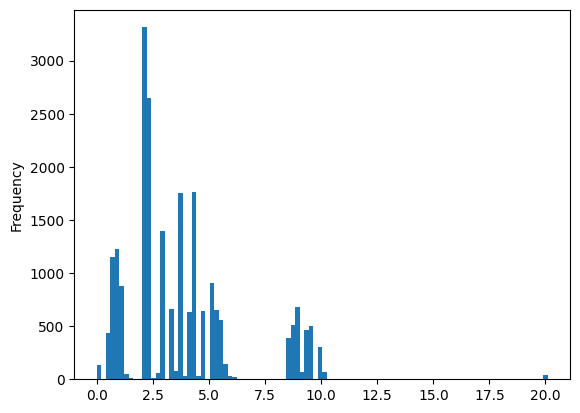

In [13]:
df.Total_UNCY = df.Total_UNCY.astype(float)
df.Total_UNCY.plot.hist(bins=100)

In [14]:
df.groupby("filename").Total_UNCY.mean().sort_values(ascending=False).head(50)

filename
Retrolens/Marlborough/CloudyBay/Shorelines/CloudyBay_02FEB2016.shp                                  20.106837
Retrolens/Marlborough/WairauRiver/Shorelines/WairauRiver_07JAN2016.shp                              20.051572
Retrolens/Marlborough/CliffordBay/Shorelines/CliffordBay_07JAN2016.shp                              20.023509
Retrolens/Nelson/BoulderBank/Shorelines/BoulderBank_06FEB1967.shp                                   10.502980
Retrolens/Tasman/MoutereSpit/Shorelines/MoutereSpit_04FEB1967.shp                                   10.483475
Retrolens/WestCoast/Mokihinui_Ngakawau/Shorelines/Mokihinui_Ngakawau_06FEB1967.shp                  10.413466
Retrolens/WestCoast/Ngakawau_WaimangaroaRiver/Shorelines/Ngakawau_WaimangaroaRiver_06FEB1967.shp    10.412744
Retrolens/Southland/CurioBay/Shorelines/CurioBay_21FEB1967.shp                                      10.134052
Retrolens/Manawatu/HokioBeach/Shorelines/HokioBeach_30NOV1978.shp                                   10.098465
R

In [15]:
df.groupby("Source").Total_UNCY.mean().sort_values(ascending=False).head(50)

Source
RS     6.813094
RL     5.408608
CRI    5.066792
RLN    4.924923
RLS    4.916569
Rl     3.714563
NEO    3.242751
JIL    3.095256
PLE    3.034761
MAX    3.017358
SAT    2.975786
Max    2.362258
JIN    2.331288
max    2.277503
WV3    2.260818
PNE    2.256973
GE1    2.199101
VEX    2.162227
LDS    2.094196
Name: Total_UNCY, dtype: float64

In [16]:
df.Photoscale.value_counts()

Photoscale
25000    1380
16000    1083
50000     632
44500     521
24000     476
         ... 
18850       1
19600       1
35100       1
8300        1
51500       1
Name: count, Length: 105, dtype: int64

In [17]:
df.Georef_ER.value_counts(dropna=False)

Georef_ER
2.020000    6935
0.000000    5234
3.610000    2930
4.200000    2893
5.030000    2702
2.596504    1568
NaN          542
Name: count, dtype: int64